In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from typing import Tuple

Function to minimize

In [2]:
def rss(labels: np.ndarray, predictions: np.ndarray):
    return np.sum(np.square(labels-predictions))

Syntethic data generation. As usually happens, X is given back with shape (N,1), which is more general than the array version (it should be able to deal with multiple features as well).

In [11]:
SEED = 0

In [12]:
def generate(N: int, noise: float, seed: int = 0) -> Tuple[np.ndarray, np.ndarray]:

    np.random.seed(seed)
    
    X = np.random.randn(N)

    y = np.sin(X) + noise * np.random.randn(N)

    return X.reshape(-1,1), y

### Linear regression with OLS closed formula. 
The implementation follows scikit-learn Linear Regression.

In [19]:
def linear_regression(X: np.ndarray, y: np.ndarray) -> Tuple[float, np.ndarray]:

    X_std = X.std(axis = 0)
    X_mean = X.mean(axis=0)
    Y_mean = y.mean(axis = 0)

    X = (X - X_mean)/X_std
    y = y - Y_mean

    coef = np.linalg.inv(X.T @ X) @ X.T @ y
    coef /= X_std
    
    intercept = Y_mean - np.dot(X_mean, coef.T)
    return intercept, coef

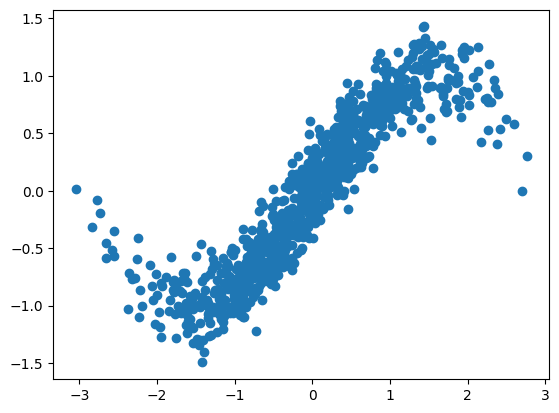

In [20]:
X,y = generate(N=1000, noise=0.2, seed=SEED)
plt.scatter(X, y);

In [28]:
intercept, coefficients = linear_regression(X,y)
ols_predictions = intercept + X @ coefficients

In [26]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
sklearn_prediction = linear_regressor.predict(X)

Let's compare weights.

In [27]:
intercepts = [linear_regressor.intercept_, intercept]
weights = [linear_regressor.coef_, coefficients]

df = pd.DataFrame({"intercept" : intercepts, "coefficient" : weights}, index=["ScikitLearn", "OLS"])

df

,intercept,coefficient
ScikitLearn,-0.002607,[0.6069833633781788]
OLS,-0.002607,[0.6069833633781785]


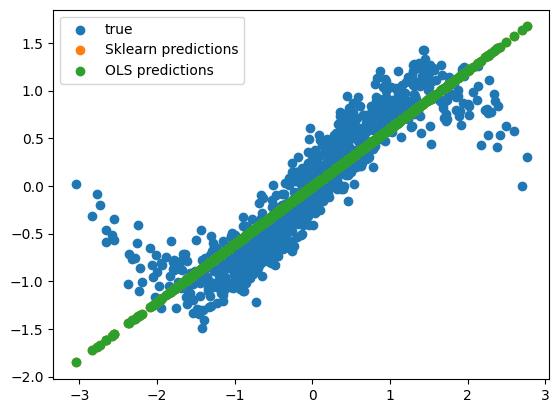

In [29]:
plt.scatter(X, y, label="true")
plt.scatter(X, sklearn_prediction, label="Sklearn predictions")
plt.scatter(X, ols_predictions, label="OLS predictions")
plt.legend();

In [30]:
print(f"Scikit Learn rss = {rss(labels=y, predictions=sklearn_prediction)}")
print(f"OLS rss = {rss(labels=y, predictions=ols_predictions)}")

Scikit Learn rss = 91.70136427335896
OLS rss = 91.70136427335896


### Gradient descent.

We'll minimize rss leveraging gradient descent.

![image](images/gradient_rss.png)

Gradient descent implementation. 

In [40]:
def gradient_intercept(X: np.ndarray, y: np.ndarray, w: np.ndarray):
    return -2 * np.sum(y - (X * w[1] + w[0]))

    # g = 0
    # for i in range(X.shape[0]):
    #     g += y[i] - (w[1] * X[i] + w[0])
    # return -2 * g

def gradient_coef(X: np.ndarray, y: np.ndarray, w: np.ndarray):
    return -2 * np.sum((y - (X * w[1] + w[0])) * X)

    # g = 0
    # for i in range(X.shape[0]):
    #     g += (y[i] - (w[1] * X[i] + w[0])) * X[i]
    # return -2 * g

def rss_gradient_descent(X: np.ndarray, y: np.ndarray, num_iter: int) -> Tuple[float, float]:

    weights = np.zeros(2)

    lr = 0.001

    # Notice that X is reshaped to be vector-like to leverage numpy broadcasting.

    if len(X.shape) == 2:
        X = X.reshape(-1)

    for i in range(num_iter):

        g0 = gradient_intercept(X, y, weights)
        g1 = gradient_coef(X, y, weights)

        # Divide by i+1 to decrease the learning rate 
        # as the number of iterations increases
        # in order to ease the convergence of the algorithm.
        
        w0 = weights[0] - lr/(i+1) * g0
        w1 = weights[1] - lr/(i+1) * g1

        nw = np.array([w0,w1])
        
        if np.linalg.norm(nw-weights) < 1e-5:

            print(f"Stop at iteration {i+1}")
            break

        weights = nw

    return nw[0], nw[1]

In [45]:
gd_intercept, gd_weight = rss_gradient_descent(X=X, y=y, num_iter=1000)

Stop at iteration 26


In [57]:
gd_predictions = gd_intercept + X * gd_weight

In [51]:
final_df = pd.concat([df, pd.DataFrame({"intercept" : gd_intercept, "coefficient": gd_weight}, index=["GD"])])
final_df

,intercept,coefficient
ScikitLearn,-0.002607,[0.6069833633781788]
OLS,-0.002607,[0.6069833633781785]
GD,-0.002509,0.607056


In [56]:
final_df['RSS'] = final_df.apply(lambda row: rss(labels=y, predictions=row['coefficient'] * X + row['intercept']), axis=1)

final_df['RSS']

ScikitLearn    809573.434248
OLS            809573.434248
GD             809659.813280
Name: RSS, dtype: float64

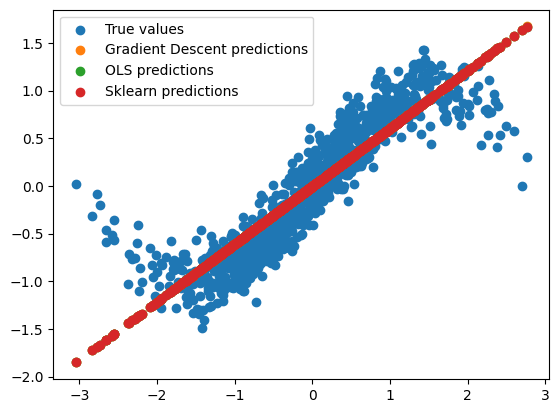

In [59]:
plt.scatter(X, y,label="True values")
plt.scatter(X, gd_predictions, label="Gradient Descent predictions")
plt.scatter(X, ols_predictions, label="OLS predictions")
plt.scatter(X, sklearn_prediction, label="Sklearn predictions")
plt.legend();